# Resolução da 2° Prova de PAA - 2024.2 - Jânio Coutinho

Breno Murilo Alexandre Reis Santos - 202100022701   
João Rosa Conceição - 202100023093   
Matheus Araujo Pereira - 202100114080   

## Imports

In [6]:
import time, math, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull
from collections import OrderedDict

## Questão 1

### a) Função para ler o conjunto de pontos e armazenar em 2 vetores, um vetor X com as primeiras coordenadas e um vetor Y com as segundas coordenadas.

In [7]:
def ler_pontos(nome_arquivo):
    """
    Lê um arquivo contendo coordenadas bi-dimensionais e armazena
    os valores em dois vetores: coordenadas_x e coordenadas_y.

    Formato esperado:
    - Primeira linha: número inteiro N de pontos.
    - Linhas seguintes: duas coordenadas separadas por vírgula, ex: 1.0, 2.5

    Parâmetros:
    - nome_arquivo (str): caminho do arquivo com os pontos.

    Retorna:
    - coordenadas_x (list[float]): lista com as coordenadas x.
    - coordenadas_y (list[float]): lista com as coordenadas y.
    """
    with open(nome_arquivo, "r") as arquivo:
        numero_pontos = int(arquivo.readline().strip())
        coordenadas_x, coordenadas_y = [], []

        for _ in range(numero_pontos):
            linha = arquivo.readline().strip().split(",")
            coordenadas_x.append(float(linha[0]))
            coordenadas_y.append(float(linha[1]))

    return coordenadas_x, coordenadas_y

### b) Função poly(X, k)

In [8]:
def poly(coordenadas_x, grau):
    """
    Gera uma matriz (lista de listas) onde cada linha contém as potências
    de x no intervalo [grau, 0]. Assim, cada linha terá (grau + 1) colunas.

    Parâmetros:
    - coordenadas_x (list[float]): lista dos valores de x.
    - grau (int): grau máximo de elevação.

    Retorna:
    - matriz (list[list[float]]): matriz com as potências de x, onde a linha i
      corresponde aos valores de coordenadas_x[i] elevados a grau, grau-1, ..., 0.
    """
    matriz = []
    for x in coordenadas_x:
        linha_de_valores = []
        for expoente in range(grau, -1, -1):
            linha_de_valores.append(x**expoente)
        matriz.append(linha_de_valores)
    return matriz

### c) Função inv(M)

In [9]:
def inv(matriz):
    """
    Inverte uma matriz quadrada por meio de eliminação Gaussiana,
    utilizando pivoteamento para melhorar a estabilidade numérica.

    Parâmetros:
    - matriz (list[list[float]]): matriz quadrada a ser invertida

    Retorna:
    - (list[list[float]]): a matriz invertida
    """
    n = len(matriz)
    # Cria a matriz identidade para realizar as operações
    identidade = [[float(i == j) for j in range(n)] for i in range(n)]
    # Faz uma cópia da matriz original para não alterá-la
    mat_copia = [linha[:] for linha in matriz]

    for i in range(n):
        # Pivô
        pivo = mat_copia[i][i]
        if abs(pivo) < 1e-12:  # Evita divisões por zero ou pivôs muito pequenos
            # Tenta encontrar uma linha adequada para trocar
            for r in range(i + 1, n):
                if abs(mat_copia[r][i]) > abs(pivo):
                    mat_copia[i], mat_copia[r] = mat_copia[r], mat_copia[i]
                    identidade[i], identidade[r] = identidade[r], identidade[i]
                    pivo = mat_copia[i][i]
                    break
        # Normaliza a linha i para que o pivô vire 1
        for c in range(n):
            mat_copia[i][c] /= pivo
            identidade[i][c] /= pivo

        # Elimina o elemento abaixo e acima do pivô
        for r in range(n):
            if r != i:
                fator = mat_copia[r][i]
                for c in range(n):
                    mat_copia[r][c] -= fator * mat_copia[i][c]
                    identidade[r][c] -= fator * identidade[i][c]

    return identidade

### d) Função ajusta(X, Y, k) com tempo do cálculo de P e SSE.

In [10]:
def transposta(matriz):
    """
    Retorna a transposta de 'matriz', convertendo linhas em colunas e vice-versa.

    Parâmetros:
    - matriz (list[list[float]]): matriz que se deseja transpor.

    Retorna:
    - list[list[float]]: matriz transposta.
    """
    # A função zip(*matriz) agrupa elementos de cada linha, formando colunas
    # O list(linha) converte cada tupla resultante em lista
    return [list(linha) for linha in zip(*matriz)]

In [11]:
def matmul(matriz_a, matriz_b):
    """
    Retorna o produto de duas matrizes (matriz_a x matriz_b).

    Parâmetros:
    - matriz_a (list[list[float]]): primeira matriz.
    - matriz_b (list[list[float]]): segunda matriz.

    Retorna:
    - list[list[float]]: resultado da multiplicação de matriz_a por matriz_b.
    """
    linhas_a, colunas_a = len(matriz_a), len(matriz_a[0])
    linhas_b, colunas_b = len(matriz_b), len(matriz_b[0])

    # Confere se a multiplicação é possível
    # (o número de colunas de A deve ser igual ao número de linhas de B)
    if colunas_a != linhas_b:
        raise ValueError("Dimensões inválidas para a multiplicação de matrizes.")

    # Inicializa a matriz resultado com zeros
    resultado = [[0.0] * colunas_b for _ in range(linhas_a)]

    # Percorre cada célula da matriz resultado efetuando as somas necessárias
    for i in range(linhas_a):
        for j in range(colunas_b):
            soma = 0.0
            for k in range(colunas_a):
                soma += matriz_a[i][k] * matriz_b[k][j]
            resultado[i][j] = soma

    return resultado

In [12]:
def ajusta(valores_x, valores_y, grau):
    """
    Ajusta um polinômio de grau 'grau' ao conjunto de pontos (valores_x, valores_y)
    utilizando o método dos mínimos quadrados. Retorna os coeficientes P,
    o tempo de execução e o valor do SSE (Soma dos Quadrados dos Erros).

    Parâmetros:
    - valores_x (list[float]): coordenadas x dos pontos.
    - valores_y (list[float]): coordenadas y dos pontos.
    - grau (int): grau do polinômio.

    Retorna:
    - coeficientes (list[float]): coeficientes do polinômio ajustado.
    - tempo_execucao (float): tempo de execução do cálculo.
    - SSE (float): soma dos quadrados dos erros entre valores preditos e observados.
    """
    inicio = time.time()

    # Matriz A resultante da função poly
    matriz_a = poly(valores_x, grau)
    # Transposta de A
    matriz_a_transposta = transposta(matriz_a)
    # Produto A^T * A
    matriz_intermediaria = matmul(matriz_a_transposta, matriz_a)
    # Inversão de A^T * A
    matriz_inversa = inv(matriz_intermediaria)
    # Criação de um vetor coluna para Y
    vetor_coluna_y = [[y] for y in valores_y]
    # Cálculo dos coeficientes P = inv(A^T A) * A^T * Y
    matriz_coeficientes = matmul(
        matriz_inversa, matmul(matriz_a_transposta, vetor_coluna_y)
    )
    coeficientes = [linha[0] for linha in matriz_coeficientes]

    # Cálculo da soma dos quadrados dos erros (SSE)
    SSE = 0
    for i, x in enumerate(valores_x):
        valor_predito = 0
        for j in range(grau + 1):
            valor_predito += matriz_a[i][j] * coeficientes[j]
        SSE += (valor_predito - valores_y[i]) ** 2

    tempo_execucao = time.time() - inicio
    return coeficientes, tempo_execucao, SSE

### e) Preencher a tabela com os 3 arquivos enviados ("a1.txt", "a2-1.txt" e "a3-1.txt")

In [13]:
def calcula_ajustes(arquivos):
    """
    Para cada arquivo em 'arquivos', e para cada grau escolhido, aplica o
    ajuste polinomial e registra o arquivo, o grau, o tempo de execução
    e o SSE (Soma dos Quadrados dos Erros).

    Parâmetros:
    - arquivos (list[str]): lista com os nomes de arquivos de dados.

    Retorna:
    - list[tuple]: lista de tuplas (arquivo, grau, tempo_execucao, SSE).
    """
    ks = [1, 2, 10]
    resultados = []
    for idx, arquivo in enumerate(arquivos, start=1):
        for k_val in ks:
            X, Y = ler_pontos(arquivo)
            P, tempo_calc, SSE = ajusta(X, Y, k_val)
            resultados.append((arquivo, k_val, tempo_calc, SSE))
    return resultados

In [14]:
def mostrar_tabela(resultados):
    """
    Exibe os resultados em formato de tabela simples,
    apresentando arquivo, grau, tempo de execução e SSE.

    Parâmetros:
    - resultados (list[tuple]): lista de tuplas (arquivo, grau, tempo_execucao, SSE).
    """
    print("| Arquivo | k | Tempo de Execução | SSE |")
    for arq, k_val, tempo, sse in resultados:
        print(f"| {arq} | {k_val} | {tempo:.6f} | {sse:.6f} |")

In [15]:
arquivos = ["a1.txt", "a2-1.txt", "a3-1.txt"]
resultados = calcula_ajustes(arquivos)
mostrar_tabela(resultados)

| Arquivo | k | Tempo de Execução | SSE |
| a1.txt | 1 | 0.001824 | 562627.134500 |
| a1.txt | 2 | 0.002284 | 277824.003057 |
| a1.txt | 10 | 0.008077 | 24109.383454 |
| a2-1.txt | 1 | 0.008791 | 1648787.351667 |
| a2-1.txt | 2 | 0.063617 | 244506.810764 |
| a2-1.txt | 10 | 0.086523 | 244367.432403 |
| a3-1.txt | 1 | 0.223677 | 9590.351581 |
| a3-1.txt | 2 | 0.266117 | 9144.300210 |
| a3-1.txt | 10 | 1.279132 | 408.293337 |


### f) Complexidade teórica

A complexidade de tempo teórica de cálculo de P é denominada pela construção da matriz A (poly): O(N * K), cálculo da transposta de A: O(N * K²), inversão da matriz (inv): O(K³) e multiplicação de matrizes (matmul): O(K³) para cada multiplicação. Sendo assim a complexidade total é: O(N * K + N * K² + K³ + K³) = O(N * K² + K³).

## Questão 2

### a) Transformação do problema em um problema linear

Aplicamos o logaritmo natural em ambos os lados:
   log(y) = log(p1) + p2 * x

Definindo:
   a = log(p1)

O modelo se torna:
    log(y) = a + p2 * x

Este é um modelo linear em relação aos parâmetros a e p2, que pode ser ajustado utilizando técnicas de regressão linear. Após encontrar os valores de a e p2, recuperamos o parâmetro original p1 com:
   p1 = exp(a)

Assim, transformamos o problema original em um problema linear.

### b) Função ajustaExp(X, Y)

In [16]:
def ajustaExp(valores_x, valores_y):
    """
    Ajusta a função p1 * exp(p2 * x) aos dados fornecidos (valores_x, valores_y),
    transformando em um problema linear via logaritmo. Retorna p1, p2,
    o tempo de cálculo e o SSE (Soma dos Quadrados dos Erros).

    Parâmetros:
    - valores_x (list[float]): coordenadas x dos pontos.
    - valores_y (list[float]): coordenadas y dos pontos (positivos).

    Retorna:
    - p1 (float): coeficiente multiplicativo.
    - p2 (float): coeficiente do expoente.
    - tempo_calc (float): tempo de execução do ajuste.
    - SSE (float): soma dos quadrados dos erros.
    """
    # Verifica se todos os valores de Y são positivos
    if any(y_valor <= 0 for y_valor in valores_y):
        raise ValueError(
            "Todos os valores de Y devem ser positivos para aplicar logaritmo."
        )

    inicio = time.time()

    # Aplica log em Y para linearizar o problema
    log_y = [math.log(y_valor) for y_valor in valores_y]

    # Ajusta o modelo linear: log(y) = a + p2*x
    # (usa a função 'ajusta' da questão 1 para grau 1)
    P, _, SSE_log = ajusta(valores_x, log_y, 1)

    a = P[1]  # intercepto no modelo linear
    p2 = P[0]  # coeficiente de x no modelo linear
    p1 = math.exp(a)  # recupera p1 original

    tempo_calc = time.time() - inicio

    # Ajusta SSE ao modelo exponencial diretamente:
    SSE = 0
    for i, x_valor in enumerate(valores_x):
        pred = p1 * math.exp(p2 * x_valor)
        SSE += (pred - valores_y[i]) ** 2

    return p1, p2, tempo_calc, SSE

In [17]:
def gerar_dados_exponenciais(p1, p2, valores_x):
    """
    Gera valores de y = p1 * exp(p2 * x) para cada x em valores_x.

    Parâmetros:
    - p1 (float): coeficiente multiplicativo do modelo exponencial.
    - p2 (float): expoente do modelo exponencial.
    - valores_x (list[float]): lista de valores para x.

    Retorna:
    - list[float]: lista de valores calculados para y.
    """
    return [p1 * math.exp(p2 * x_valor) for x_valor in valores_x]

In [18]:
# Exemplo de uso com dados fictícios mais amplos
valores_x_exemplo = [i * 0.5 for i in range(11)]
p1_real, p2_real = 5.0, 0.3
valores_y_exemplo = gerar_dados_exponenciais(p1_real, p2_real, valores_x_exemplo)

In [19]:
p1_ajustado, p2_ajustado, tempo_exec, SSE = ajustaExp(
    valores_x_exemplo, valores_y_exemplo
)
print("Exemplo de ajuste exponencial:")
print(f"p1 ajustado: {p1_ajustado:.4f}, p2 ajustado: {p2_ajustado:.4f}")
print(f"Tempo de cálculo: {tempo_exec:.6f}s, SSE: {SSE:.6f}")

Exemplo de ajuste exponencial:
p1 ajustado: 5.0000, p2 ajustado: 0.3000
Tempo de cálculo: 0.000135s, SSE: 0.000000


In [20]:
# Exemplo adicional 1
valores_x_exemplo2 = [i for i in range(0, 8)]
p1_real2, p2_real2 = 2.5, 0.7
valores_y_exemplo2 = gerar_dados_exponenciais(p1_real2, p2_real2, valores_x_exemplo2)
p1_ajustado2, p2_ajustado2, tempo_exec2, SSE2 = ajustaExp(
    valores_x_exemplo2, valores_y_exemplo2
)
print("\nExemplo de ajuste exponencial (2):")
print(f"p1 ajustado: {p1_ajustado2:.4f}, p2 ajustado: {p2_ajustado2:.4f}")
print(f"Tempo de cálculo: {tempo_exec2:.6f}s, SSE: {SSE2:.6f}")


Exemplo de ajuste exponencial (2):
p1 ajustado: 2.5000, p2 ajustado: 0.7000
Tempo de cálculo: 0.000083s, SSE: 0.000000


In [21]:
# Exemplo adicional 2
valores_x_exemplo3 = [x * 0.1 for x in range(10)]
p1_real3, p2_real3 = 1.0, -0.5
valores_y_exemplo3 = gerar_dados_exponenciais(p1_real3, p2_real3, valores_x_exemplo3)
p1_ajustado3, p2_ajustado3, tempo_exec3, SSE3 = ajustaExp(
    valores_x_exemplo3, valores_y_exemplo3
)
print("\nExemplo de ajuste exponencial (3):")
print(f"p1 ajustado: {p1_ajustado3:.4f}, p2 ajustado: {p2_ajustado3:.4f}")
print(f"Tempo de cálculo: {tempo_exec3:.6f}s, SSE: {SSE3:.6f}")


Exemplo de ajuste exponencial (3):
p1 ajustado: 1.0000, p2 ajustado: -0.5000
Tempo de cálculo: 0.000056s, SSE: 0.000000


In [22]:
def gerar_dados_exponenciais_com_ruido(p1, p2, valores_x, ruido=0.1):
    """
    Gera valores de y = p1 * exp(p2 * x) para cada x em valores_x,
    adicionando um ruído aleatório para evitar SSE zero.

    Parâmetros:
    - p1 (float): coeficiente multiplicativo do modelo exponencial.
    - p2 (float): expoente do modelo exponencial.
    - valores_x (list[float]): lista de valores para x.
    - ruido (float): escala do ruído randômico a ser adicionado aos dados.

    Retorna:
    - list[float]: lista de valores calculados para y, com ruído.
    """
    return [
        (p1 * math.exp(p2 * x_valor)) + (ruido * random.random())
        for x_valor in valores_x
    ]

In [23]:
# Exemplo com ruído para gerar SSE não-nulo
valores_x_exemplo4 = [i for i in range(6)]
p1_real4, p2_real4 = 2.0, 0.3
valores_y_exemplo4 = gerar_dados_exponenciais_com_ruido(
    p1_real4, p2_real4, valores_x_exemplo4, ruido=0.2
)

p1_ajustado4, p2_ajustado4, tempo_exec4, SSE4 = ajustaExp(
    valores_x_exemplo4, valores_y_exemplo4
)
print("\nExemplo de ajuste exponencial (com ruído):")
print(f"p1 ajustado: {p1_ajustado4:.4f}, p2 ajustado: {p2_ajustado4:.4f}")
print(f"Tempo de cálculo: {tempo_exec4:.6f}s, SSE: {SSE4:.6f}")


Exemplo de ajuste exponencial (com ruído):
p1 ajustado: 2.1214, p2 ajustado: 0.2883
Tempo de cálculo: 0.000062s, SSE: 0.023240


## Questão 3

### a) Função pol(P)

In [24]:
def mediana(valores):
    """
    Calcula a mediana de uma lista de valores reais.

    Se a lista tiver tamanho ímpar, retorna o valor central.
    Se for par, retorna a média dos dois valores centrais.

    Parâmetros:
    - valores (list[float]): lista de números reais.

    Retorna:
    - float: valor da mediana.
    """
    valores_ordenados = sorted(valores)
    n = len(valores_ordenados)
    if n % 2 == 1:
        return valores_ordenados[n // 2]
    else:
        return (valores_ordenados[n // 2 - 1] + valores_ordenados[n // 2]) / 2

In [25]:
def pol(pontos):
    """
    Determina o ponto que minimiza a soma das distâncias Manhattan
    para um conjunto de pontos no plano.

    A distância Manhattan entre dois pontos p = (x, y) e q = (x_q, y_q) é:
       d(p, q) = |x - x_q| + |y - y_q|

    O ponto que minimiza a soma das distâncias para um conjunto de pontos
    é dado pelas medianas separadas das coordenadas x e y.

    Parâmetros:
    - pontos (list[tuple[float, float]]): lista de pontos (x, y).

    Retorna:
    - tuple: (mediana_dos_x, mediana_dos_y), o ponto que minimiza a soma das
      distâncias Manhattan.
    """
    xs = [p[0] for p in pontos]
    ys = [p[1] for p in pontos]
    return (mediana(xs), mediana(ys))

In [26]:
def test_pol():
    """
    Testa a função pol(P) utilizando vários exemplos.

    São apresentados 5 exemplos:
      1. Número ímpar de pontos.
      2. Número par de pontos.
      3. Pontos com coordenadas variadas e desordenadas.
      4. Pontos com todas as coordenadas x iguais.
      5. Pontos com um grande spread nas coordenadas y.
    """
    # Exemplo 1: Número ímpar de pontos
    pontos1 = [(1, 2), (3, 4), (5, 6)]
    resultado1 = pol(pontos1)
    print("Exemplo 1 (número ímpar de pontos):")
    print("Pontos:", pontos1)
    print("Ponto que minimiza a soma Manhattan:", resultado1)
    print("-" * 50)

    # Exemplo 2: Número par de pontos
    pontos2 = [(1, 2), (3, 4), (7, 8), (9, 10)]
    resultado2 = pol(pontos2)
    print("Exemplo 2 (número par de pontos):")
    print("Pontos:", pontos2)
    print("Ponto que minimiza a soma Manhattan:", resultado2)
    print("-" * 50)

    # Exemplo 3: Pontos variados e desordenados
    pontos3 = [(5, 1), (2, 8), (9, 3), (4, 7), (6, 5), (3, 9)]
    resultado3 = pol(pontos3)
    print("Exemplo 3 (pontos variados):")
    print("Pontos:", pontos3)
    print("Ponto que minimiza a soma Manhattan:", resultado3)
    print("-" * 50)

    # Exemplo 4: Pontos com todas as coordenadas x iguais
    pontos4 = [(4, 2), (4, 10), (4, 5)]
    resultado4 = pol(pontos4)
    print("Exemplo 4 (coordenadas x constantes):")
    print("Pontos:", pontos4)
    print("Ponto que minimiza a soma Manhattan:", resultado4)
    print("-" * 50)

    # Exemplo 5: Pontos com grande dispersão em y
    pontos5 = [(1, 100), (2, -50), (3, 20), (4, 0), (5, -30)]
    resultado5 = pol(pontos5)
    print("Exemplo 5 (spread em y):")
    print("Pontos:", pontos5)
    print("Ponto que minimiza a soma Manhattan:", resultado5)

In [27]:
# Execução dos testes
test_pol()

Exemplo 1 (número ímpar de pontos):
Pontos: [(1, 2), (3, 4), (5, 6)]
Ponto que minimiza a soma Manhattan: (3, 4)
--------------------------------------------------
Exemplo 2 (número par de pontos):
Pontos: [(1, 2), (3, 4), (7, 8), (9, 10)]
Ponto que minimiza a soma Manhattan: (5.0, 6.0)
--------------------------------------------------
Exemplo 3 (pontos variados):
Pontos: [(5, 1), (2, 8), (9, 3), (4, 7), (6, 5), (3, 9)]
Ponto que minimiza a soma Manhattan: (4.5, 6.0)
--------------------------------------------------
Exemplo 4 (coordenadas x constantes):
Pontos: [(4, 2), (4, 10), (4, 5)]
Ponto que minimiza a soma Manhattan: (4, 5)
--------------------------------------------------
Exemplo 5 (spread em y):
Pontos: [(1, 100), (2, -50), (3, 20), (4, 0), (5, -30)]
Ponto que minimiza a soma Manhattan: (3, 0)


### b) Qual a complexidade de tempo da sua solução?

A complexidade de tempo da função pol(P) é O(n log n), pois para cada dimensão (x e y) é preciso ordenar a lista de valores, o que tem complexidade O(n log n). Como são duas ordenações, a complexidade total permanece O(n log n).

## Questão 3 - QUICK SELECT

### a) Função pol(P)

In [28]:
def quickselect(elementos, posicao):
    """
    Retorna o elemento na 'posicao' (k-ésimo menor) de 'elementos',
    usando o algoritmo Quickselect.

    :param elementos: Lista de valores na qual desejamos encontrar o k-ésimo menor elemento.
    :param posicao: Índice (baseado em zero) do elemento desejado.
    :return: O elemento localizado na posição específica.
    """
    if len(elementos) == 1:
        return elementos[0]

    pivô = random.choice(
        elementos
    )  # Escolhe um pivô aleatório para eficiência média O(n)

    elementos_menores = [x for x in elementos if x < pivô]
    elementos_iguais = [x for x in elementos if x == pivô]
    elementos_maiores = [x for x in elementos if x > pivô]

    if posicao < len(elementos_menores):
        return quickselect(elementos_menores, posicao)
    elif posicao < len(elementos_menores) + len(elementos_iguais):
        return pivô
    else:
        return quickselect(
            elementos_maiores, posicao - len(elementos_menores) - len(elementos_iguais)
        )

In [29]:
def mediana(elementos):
    """
    Retorna a mediana de uma lista de valores utilizando a função quickselect.
    Se a lista tiver tamanho ímpar, retorna o elemento central.
    Se tiver tamanho par, retorna a média dos dois elementos centrais.

    :param elementos: Lista de valores numéricos.
    :return: A mediana dos valores na lista.
    """
    tamanho = len(elementos)
    if tamanho % 2 == 1:
        return quickselect(elementos, tamanho // 2)
    else:
        return (
            quickselect(elementos, tamanho // 2 - 1)
            + quickselect(elementos, tamanho // 2)
        ) / 2

In [30]:
def pol(pontos):
    """
    Retorna o ponto que minimiza a soma das distâncias Manhattan em uma lista de pontos,
    calculando a mediana de suas coordenadas x e y.

    :param pontos: Lista de tuplas (x, y) representando os pontos.
    :return: Tupla (mediana_x, mediana_y) do conjunto de pontos.
    """
    valores_x = [p[0] for p in pontos]
    valores_y = [p[1] for p in pontos]
    return mediana(valores_x), mediana(valores_y)

In [31]:
def test_pol():
    """
    Testa a função 'pol' com diferentes conjuntos de pontos, imprimindo o ponto
    resultante que minimiza a soma das distâncias Manhattan.
    """
    test_cases = [
        ([(1, 2), (3, 4), (5, 6)], "ímpar pequeno"),
        ([(1, 2), (3, 4), (7, 8), (9, 10)], "par pequeno"),
        ([(1, 10), (2, 9), (3, 8), (4, 7), (5, 6)], "ímpar médio"),
        ([(2, 3), (2, 5), (4, 1), (6, 7), (6, 4)], "ímpar variado"),
        ([(10, 10), (20, 20), (30, 30), (40, 40)], "par crescente"),
        ([(5, 5), (5, 5), (5, 5), (5, 5)], "par duplicado"),
        ([(1, 1), (2, 2), (3, 3)], "ímpar diagonal"),
        ([(10, 1), (8, 5), (7, 9), (3, 3)], "par aleatório"),
        ([(9, 1), (8, 0), (9, 2), (7, 2), (10, 1)], "ímpar aproximado"),
        ([(2, 2), (2, 3), (3, 2), (3, 3)], "par próximo"),
    ]

    for pontos, nome in test_cases:
        resultado = pol(pontos)
        print(f"Teste ({nome}):")
        print(f"Pontos: {pontos}")
        print(f"Ponto que minimiza a soma Manhattan = {resultado}\n")


test_pol()

Teste (ímpar pequeno):
Pontos: [(1, 2), (3, 4), (5, 6)]
Ponto que minimiza a soma Manhattan = (3, 4)

Teste (par pequeno):
Pontos: [(1, 2), (3, 4), (7, 8), (9, 10)]
Ponto que minimiza a soma Manhattan = (5.0, 6.0)

Teste (ímpar médio):
Pontos: [(1, 10), (2, 9), (3, 8), (4, 7), (5, 6)]
Ponto que minimiza a soma Manhattan = (3, 8)

Teste (ímpar variado):
Pontos: [(2, 3), (2, 5), (4, 1), (6, 7), (6, 4)]
Ponto que minimiza a soma Manhattan = (4, 4)

Teste (par crescente):
Pontos: [(10, 10), (20, 20), (30, 30), (40, 40)]
Ponto que minimiza a soma Manhattan = (25.0, 25.0)

Teste (par duplicado):
Pontos: [(5, 5), (5, 5), (5, 5), (5, 5)]
Ponto que minimiza a soma Manhattan = (5.0, 5.0)

Teste (ímpar diagonal):
Pontos: [(1, 1), (2, 2), (3, 3)]
Ponto que minimiza a soma Manhattan = (2, 2)

Teste (par aleatório):
Pontos: [(10, 1), (8, 5), (7, 9), (3, 3)]
Ponto que minimiza a soma Manhattan = (7.5, 4.0)

Teste (ímpar aproximado):
Pontos: [(9, 1), (8, 0), (9, 2), (7, 2), (10, 1)]
Ponto que minimiza

### b) Qual a complexidade de tempo da sua solução?

A cada chamada de pol, encontramos as medianas (x e y) chamando internamente quickselect (média de O(n) em cada chamada). Portanto, cada execução de pol tem complexidade média O(n). O pior caso do Quickselect é O(n²), mas na prática costuma ser O(n).

## Questão 4

### a) Função inTri(P)

In [32]:
def convexHull_sc(pontos):
    """
    Calcula o casco convexo do conjunto de pontos utilizando SciPy.

    Parâmetros:
    - pontos (list[tuple[float, float]]): lista de pontos (x, y).

    Retorna:
    - list[tuple[float, float]]: pontos que formam o casco convexo, em ordem.
    """
    pontos_array = np.array(pontos)
    hull = ConvexHull(pontos_array)
    hull_indices = hull.vertices
    return [tuple(pontos_array[i]) for i in hull_indices]

In [33]:
def inTri(pontos):
    """
    Verifica se o casco convexo do conjunto 'pontos' é formado por exatamente 3 vértices.

    Se sim, significa que todos os pontos estão contidos em um triângulo
    formado pelos vértices do casco convexo.

    Parâmetros:
    - pontos (list[tuple[float, float]]): lista de pontos (x, y).

    Retorna:
    - bool: True se o casco convexo tem 3 vértices, False caso contrário.
    """
    return len(convexHull_sc(pontos)) == 3

In [34]:
def plot_exemplo(pontos, titulo):
    """
    Plota os pontos, o casco convexo e exibe se o conjunto forma um triângulo.

    Parâmetros:
    - pontos (list[tuple[float, float]]): lista de pontos (x, y).
    - titulo (str): título para o gráfico.
    """
    pontos_array = np.array(pontos)
    hull = convexHull_sc(pontos)
    hull = np.array(
        hull + [hull[0]]
    )  # Fecha o polígono adicionando o primeiro ponto no final

    plt.figure(figsize=(6, 5))
    plt.scatter(pontos_array[:, 0], pontos_array[:, 1], color="blue", label="Pontos")
    plt.plot(hull[:, 0], hull[:, 1], "r--", lw=2, label="Casco Convexo")

    # Exibe se o casco convexo tem exatamente 3 vértices
    triangulo = inTri(pontos)
    info = "Triângulo" if triangulo else "Não é Triângulo"
    plt.title(f"{titulo}\n{info}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

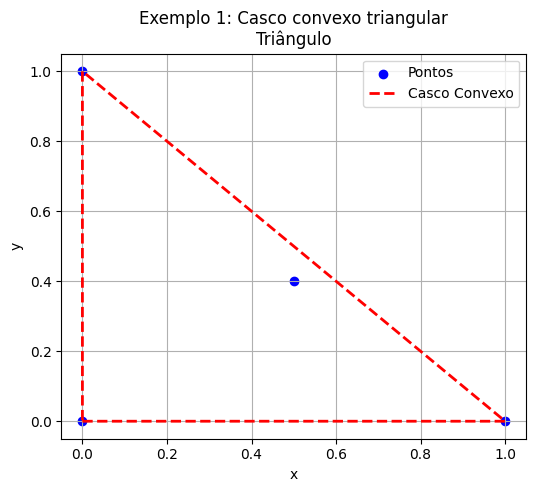

In [35]:
# Exemplo visual 1: Conjunto de pontos resultando num casco convexo triangular
pontos_ex1 = [(0, 0), (1, 0), (0, 1), (0.5, 0.4)]
plot_exemplo(pontos_ex1, "Exemplo 1: Casco convexo triangular")

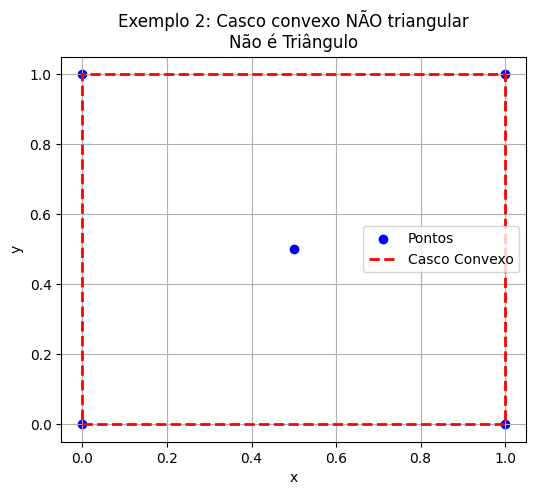

In [36]:
# Exemplo visual 2: Conjunto de pontos formando um quadrilátero convexo
pontos_ex2 = [(0, 0), (1, 0), (1, 1), (0, 1), (0.5, 0.5)]
plot_exemplo(pontos_ex2, "Exemplo 2: Casco convexo NÃO triangular")

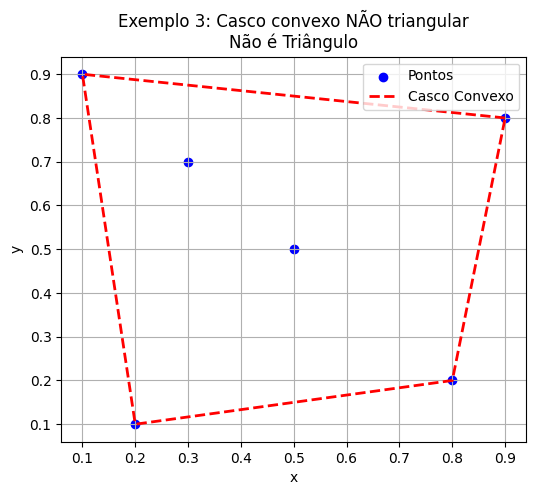

In [37]:
# Exemplo visual 3: Conjunto de pontos aleatórios com casco convexo com mais de 3 vértices
pontos_ex3 = [(0.2, 0.1), (0.8, 0.2), (0.9, 0.8), (0.5, 0.5), (0.1, 0.9), (0.3, 0.7)]
plot_exemplo(pontos_ex3, "Exemplo 3: Casco convexo NÃO triangular")

### b) Qual a complexidade de inTri(P)?

A complexidade de inTri(P) é dominada pelo cálculo do casco convexo (convexHull), que em geral possui complexidade O(n log n) para pontos em 2D. Portanto, a complexidade de inTri(P) é O(n log n).

### c) Função inCirc(P, r)

In [38]:
def inCirc(pontos, r):
    """
    Verifica se todos os pontos de 'pontos' estão contidos em um círculo de raio r,
    cujo centro é a média (centroide) dos pontos.

    Parâmetros:
    - pontos (list[tuple[float, float]]): lista de pontos (x, y).
    - r (float): raio do círculo.

    Retorna:
    - bool: True se todos os pontos estiverem dentro (ou na fronteira) do círculo,
      False caso contrário.
    """
    n = len(pontos)
    if n == 0:
        return True  # Definido como True para o caso de lista vazia.

    centro_x = sum(p[0] for p in pontos) / n
    centro_y = sum(p[1] for p in pontos) / n

    for x, y in pontos:
        if math.sqrt((x - centro_x) ** 2 + (y - centro_y) ** 2) > r:
            return False
    return True

In [39]:
def plot_inCirc(pontos, r, titulo):
    """
    Plota os pontos, o círculo de raio 'r' centrado na média dos pontos e destaca o centro.

    Parâmetros:
    - pontos (list[tuple[float, float]]): lista de pontos (x, y).
    - r (float): raio do círculo.
    - titulo (str): título para o gráfico.
    """
    pontos_array = np.array(pontos)
    n = len(pontos)
    centro_x = sum(p[0] for p in pontos) / n if n > 0 else 0
    centro_y = sum(p[1] for p in pontos) / n if n > 0 else 0

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(pontos_array[:, 0], pontos_array[:, 1], color="blue", label="Pontos")
    ax.scatter([centro_x], [centro_y], color="red", label="Centro (média)", zorder=5)

    # Cria e adiciona o círculo utilizando o Circle do matplotlib.patches
    circle = Circle(
        (centro_x, centro_y),
        r,
        color="green",
        fill=False,
        linestyle="--",
        label=f"Círculo de raio {r:.2f}",
    )
    ax.add_patch(circle)

    ax.set_xlim(min(pontos_array[:, 0]) - r, max(pontos_array[:, 0]) + r)
    ax.set_ylim(min(pontos_array[:, 1]) - r, max(pontos_array[:, 1]) + r)

    dentro = inCirc(pontos, r)
    info = "Todos os pontos DENTRO" if dentro else "Algum ponto FORA"
    ax.set_title(f"{titulo}\n{info}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)
    plt.show()

In [40]:
def test_inCirc_grafico():
    """
    Testa a função inCirc(pontos, r) e plota os resultados graficamente para 3 casos:

    Exemplo 1: Todos os pontos dentro do círculo.
    Exemplo 2: Pelo menos um ponto fora do círculo.
    Exemplo 3: Pontos exatamente na fronteira.
    """
    # Exemplo 1: Todos os pontos dentro do círculo
    pontos1 = [(1, 1), (2, 2), (1, 2), (2, 1)]
    n1 = len(pontos1)
    centro_x1 = sum(p[0] for p in pontos1) / n1
    centro_y1 = sum(p[1] for p in pontos1) / n1
    max_dist1 = max(
        math.sqrt((x - centro_x1) ** 2 + (y - centro_y1) ** 2) for x, y in pontos1
    )
    r1 = max_dist1 + 0.2
    print("Exemplo 1 - inCirc:", inCirc(pontos1, r1))
    plot_inCirc(pontos1, r1, "Exemplo 1: Pontos DENTRO do Círculo")

    # Exemplo 2: Pelo menos um ponto fora do círculo
    pontos2 = [(1, 1), (2, 2), (1, 2), (10, 10)]
    n2 = len(pontos2)
    centro_x2 = sum(p[0] for p in pontos2) / n2
    centro_y2 = sum(p[1] for p in pontos2) / n2
    max_dist2 = max(
        math.sqrt((x - centro_x2) ** 2 + (y - centro_y2) ** 2) for x, y in pontos2
    )
    r2 = max_dist2 - 1.0  # Raio menor que a distância máxima
    print("Exemplo 2 - inCirc:", inCirc(pontos2, r2))
    plot_inCirc(pontos2, r2, "Exemplo 2: Pelo menos UM ponto FORA do Círculo")

    # Exemplo 3: Pontos exatamente na fronteira do círculo
    pontos3 = [(0, 0), (2, 0), (1, math.sqrt(3))]
    n3 = len(pontos3)
    centro_x3 = sum(p[0] for p in pontos3) / n3
    centro_y3 = sum(p[1] for p in pontos3) / n3
    max_dist3 = max(
        math.sqrt((x - centro_x3) ** 2 + (y - centro_y3) ** 2) for x, y in pontos3
    )
    r3 = max_dist3  # Raio exatamente igual à distância máxima
    print("Exemplo 3 - inCirc:", inCirc(pontos3, r3))
    plot_inCirc(pontos3, r3, "Exemplo 3: Pontos na FRONTEIRA do Círculo")

Exemplo 1 - inCirc: True


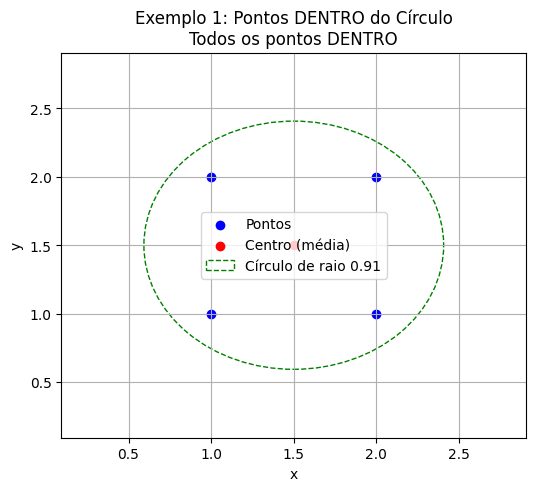

Exemplo 2 - inCirc: False


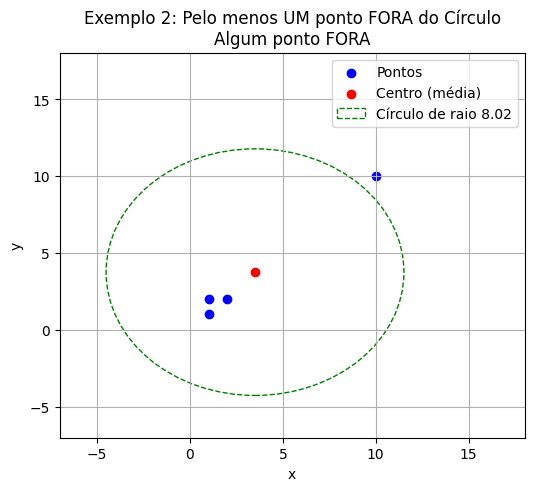

Exemplo 3 - inCirc: True


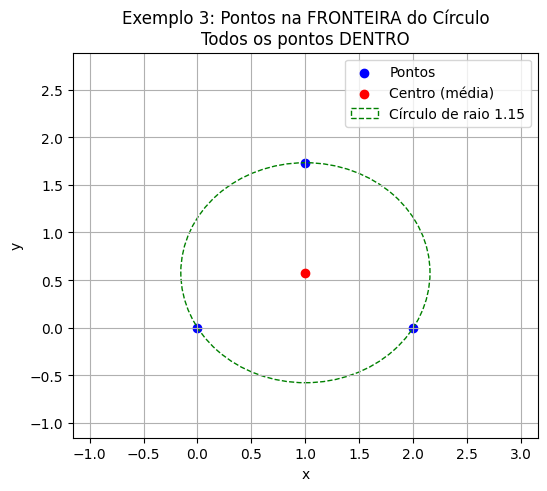

In [41]:
# Execução dos testes gráficos para inCirc
test_inCirc_grafico()

### d) Qual a complexidade de inCirc(P, r)?

A complexidade de inCirc(P, r) é O(n), onde n é o número de pontos em P, pois é necessário calcular a média dos pontos (O(n)) e depois verificar cada ponto contra o círculo (O(n)).

## Questão 5

### a) Reescrição

Utilizando a identidade da potenciação, podemos reescrever:
    c^(2p + bi) = (c^p)^2 * c^(bi)

Ou seja:
- Se bi == 0, então c^(2p + 0) = (c^p)^2
- Se bi == 1, então c^(2p + 1) = (c^p)^2 * c

Assim, no pseudo-código podemos atualizar a variável c^P como:

c^P <- c
para i de (K-1) até 0:
   c^P <- (c^P)^2
   se bi == 1:
         c^P <- c^P * c
retorne c^P

### b) Algoritmo expBin(c, Bn)

In [42]:
def expBin(base, bits_expoente):
    """
    Calcula base^N, onde N é representado pelos bits da lista bits_expoente = [b0, b1, ..., bk],
    sendo que b_k é o bit mais significativo (deve ser 1 se N > 0).

    O cálculo utiliza o método de Horner modificado, onde:
      - Inicializamos o resultado com a base (correspondente ao bit mais significativo).
      - Para cada bit, do penúltimo até o primeiro, realizamos:
            resultado = (resultado)^2
            Se o bit corrente for 1, multiplicamos o resultado por base.
      - Retornamos o resultado final.

    Exemplo:
      Para N = 13, a representação binária é 1101.
      Podemos definir bits_expoente = [1, 0, 1, 1] (onde o primeiro elemento é o bit menos significativo
      e o último é o bit mais significativo). Assim, expBin(2, [1, 0, 1, 1]) calculará 2^13.

    Parâmetros:
      - base (int ou float): a base que será elevada à potência.
      - bits_expoente (list[int]): lista de bits (0 ou 1) representando o expoente, com o bit
        menos significativo em bits_expoente[0] e o mais significativo em bits_expoente[-1].

    Retorna:
      - O valor de base elevado à potência N.
    """
    resultado = base  # Inicializa com o bit mais significativo (de N > 0)
    # Itera do penúltimo bit até o primeiro, em ordem decrescente
    for i in range(len(bits_expoente) - 2, -1, -1):
        resultado = resultado * resultado  # Eleva o resultado ao quadrado
        if bits_expoente[i] == 1:
            resultado = resultado * base  # Multiplica por base se o bit corrente é 1
    return resultado

In [43]:
# Exemplo 1: Calcular 2^13
# 13 em binário: 1101, representado como [1, 0, 1, 1] (menor para maior)
base = 2
expoente_bin1 = [1, 0, 1, 1]
print("Exemplo 1: 2^13 =", expBin(base, expoente_bin1))

Exemplo 1: 2^13 = 8192


In [44]:
# Exemplo 2: Calcular 3^19
# 19 em binário: 10011, representado como [1, 1, 0, 0, 1]
base = 3
expoente_bin2 = [1, 1, 0, 0, 1]
print("Exemplo 2: 3^19 =", expBin(base, expoente_bin2))

Exemplo 2: 3^19 = 1162261467


In [45]:
# Exemplo 3: Calcular 5^0.
# Por convenção, se a lista de bits estiver vazia, consideramos expoente 0.
# Neste caso, a função pode ser adaptada para retornar 1.
# Aqui usaremos uma verificação fora da função:
base = 5
expoente_bin3 = []  # Representação vazia indica expoente 0
print("Exemplo 3: 5^0 =", 1 if not expoente_bin3 else expBin(base, expoente_bin3))

Exemplo 3: 5^0 = 1


In [46]:
# Exemplo 4: Calcular 2^1
# 1 em binário: 1, representado como [1]
base = 2
expoente_bin4 = [1]
print("Exemplo 4: 2^1 =", expBin(base, expoente_bin4))

Exemplo 4: 2^1 = 2


In [47]:
# Exemplo 5: Calcular 7^23
# 23 em binário: 10111, representado como [1, 1, 1, 0, 1]
base = 7
expoente_bin5 = [1, 1, 1, 0, 1]
print("Exemplo 5: 7^23 =", expBin(base, expoente_bin5))

Exemplo 5: 7^23 = 27368747340080916343


### c) Qual a complexidade de tempo de expBi(c, Bn) em função de N?

A complexidade de expBin(c, Bn) é O(k), onde k é o número de bits em N.
Como k é aproximadamente log₂(N), a complexidade em função de N é O(log N).

## Questão 6

### a) Método para ordenar A eficientemente

Para ordenar N strings formadas apenas por letras minúsculas, uma boa escolha é utilizar o Radix Sort (MSD ou LSD). 

Esse algoritmo aproveita o fato de o alfabeto ser fixo (26 letras) e ordena as strings caractere a caractere.

Se L for o comprimento máximo (ou médio) das strings, a complexidade temporal do Radix Sort é O(N * L), o que pode ser muito eficiente quando L é pequeno.

### b) Função angroup(A)

In [48]:
def angroup(lista_strings):
    """
    Agrupa os anagramas presentes em uma lista de strings,
    retornando os grupos ordenados primeiro pelo número de letras e,
    em caso de empate, por ordem alfabética da chave (formada pelos caracteres ordenados).

    Duas ou mais strings são anagramas se uma é uma permutação dos símbolos da outra.
    A estratégia é:
      1. Para cada string, calcular uma "chave" obtida ao ordenar seus caracteres.
      2. Agrupar as strings que possuem a mesma chave.
      3. Ordenar internamente cada grupo (para consistência).
      4. Ordenar os grupos resultantes: primeiro pelo tamanho (número de letras) e,
         depois, pela ordem alfabética da chave.

    Parâmetros:
      - lista_strings (list[str]): lista de strings (formadas exclusivamente por letras minúsculas).

    Retorna:
      - list[list[str]]: lista de grupos de anagramas, ordenados conforme descrito.

    Exemplo:
      Entrada: ['cao', 'jaca', 'oca', 'cora', 'arar', 'ora', 'rara', 'caja', 'aco', 'aro']
      Retorno: [['aco', 'cao', 'oca'], ['aro', 'ora'], ['arar', 'rara'], ['caja', 'jaca'], ['cora']]
    """
    grupos_anagramas = {}
    for palavra in lista_strings:
        # A chave é formada pelos caracteres da palavra ordenados em ordem alfabética.
        chave = "".join(sorted(palavra))
        if chave not in grupos_anagramas:
            grupos_anagramas[chave] = []
        grupos_anagramas[chave].append(palavra)

    # Ordena internamente cada grupo para consistência
    for chave in grupos_anagramas:
        grupos_anagramas[chave].sort()

    # Ordena os grupos:
    # 1°: pelo número de caracteres (tamanho da chave)
    # 2°: pela ordem alfabética da chave
    grupos_ordenados = sorted(
        grupos_anagramas.items(), key=lambda tup: (len(tup[0]), tup[0])
    )

    # Retorna apenas os grupos (listas de anagramas) na ordem desejada.
    return [grupo for chave, grupo in grupos_ordenados]

In [49]:
# CELULA 1 - Exemplo 1
A1 = ["cao", "jaca", "oca", "cora", "arar", "ora", "rara", "caja", "aco", "aro"]
resultado1 = angroup(A1)
print("Exemplo 1 - Entrada:", A1)
print("Exemplo 1 - Grupos de anagramas:", resultado1)
print()

Exemplo 1 - Entrada: ['cao', 'jaca', 'oca', 'cora', 'arar', 'ora', 'rara', 'caja', 'aco', 'aro']
Exemplo 1 - Grupos de anagramas: [['aco', 'cao', 'oca'], ['aro', 'ora'], ['caja', 'jaca'], ['arar', 'rara'], ['cora']]



In [50]:
# CELULA 2 - Exemplo 2
A2 = ["listen", "silent", "enlist", "google", "glegoo", "inlets", "banana"]
resultado2 = angroup(A2)
print("Exemplo 2 - Entrada:", A2)
print("Exemplo 2 - Grupos de anagramas:", resultado2)
print()

Exemplo 2 - Entrada: ['listen', 'silent', 'enlist', 'google', 'glegoo', 'inlets', 'banana']
Exemplo 2 - Grupos de anagramas: [['banana'], ['glegoo', 'google'], ['enlist', 'inlets', 'listen', 'silent']]



In [51]:
# CELULA 3 - Exemplo 3
A3 = ["abc", "cab", "bac", "xyz", "zxy", "yxz", "foo", "ofo", "oof", "bar"]
resultado3 = angroup(A3)
print("Exemplo 3 - Entrada:", A3)
print("Exemplo 3 - Grupos de anagramas:", resultado3)
print()

Exemplo 3 - Entrada: ['abc', 'cab', 'bac', 'xyz', 'zxy', 'yxz', 'foo', 'ofo', 'oof', 'bar']
Exemplo 3 - Grupos de anagramas: [['abc', 'bac', 'cab'], ['bar'], ['foo', 'ofo', 'oof'], ['xyz', 'yxz', 'zxy']]



In [52]:
# CELULA 4 - Exemplo 4
A4 = ["rat", "tar", "art", "star", "tars", "cheese", "seeche"]
resultado4 = angroup(A4)
print("Exemplo 4 - Entrada:", A4)
print("Exemplo 4 - Grupos de anagramas:", resultado4)
print()

Exemplo 4 - Entrada: ['rat', 'tar', 'art', 'star', 'tars', 'cheese', 'seeche']
Exemplo 4 - Grupos de anagramas: [['art', 'rat', 'tar'], ['star', 'tars'], ['cheese', 'seeche']]



In [53]:
# CELULA 5 - Exemplo 5
A5 = ["amor", "roma", "mora", "maro", "ramo", "omar"]
resultado5 = angroup(A5)
print("Exemplo 5 - Entrada:", A5)
print("Exemplo 5 - Grupos de anagramas:", resultado5)
print()

Exemplo 5 - Entrada: ['amor', 'roma', 'mora', 'maro', 'ramo', 'omar']
Exemplo 5 - Grupos de anagramas: [['amor', 'maro', 'mora', 'omar', 'ramo', 'roma']]



In [54]:
# CELULA 6 - Exemplo 6
A6 = ["at", "ta", "bat", "tab", "abt", "cat", "act"]
resultado6 = angroup(A6)
print("Exemplo 6 - Entrada:", A6)
print("Exemplo 6 - Grupos de anagramas:", resultado6)
print()

Exemplo 6 - Entrada: ['at', 'ta', 'bat', 'tab', 'abt', 'cat', 'act']
Exemplo 6 - Grupos de anagramas: [['at', 'ta'], ['abt', 'bat', 'tab'], ['act', 'cat']]



In [55]:
# CELULA 7 - Exemplo 7
A7 = ["dorm", "mord", "norm", "rond", "dorn", "random", "adnorm"]
resultado7 = angroup(A7)
print("Exemplo 7 - Entrada:", A7)
print("Exemplo 7 - Grupos de anagramas:", resultado7)
print()

Exemplo 7 - Entrada: ['dorm', 'mord', 'norm', 'rond', 'dorn', 'random', 'adnorm']
Exemplo 7 - Grupos de anagramas: [['dorm', 'mord'], ['dorn', 'rond'], ['norm'], ['adnorm', 'random']]



In [56]:
# CELULA 8 - Exemplo 8
A8 = ["abacate", "cabaate", "tabaeca", "banana", "ananab", "nabana"]
resultado8 = angroup(A8)
print("Exemplo 8 - Entrada:", A8)
print("Exemplo 8 - Grupos de anagramas:", resultado8)
print()

Exemplo 8 - Entrada: ['abacate', 'cabaate', 'tabaeca', 'banana', 'ananab', 'nabana']
Exemplo 8 - Grupos de anagramas: [['ananab', 'banana', 'nabana'], ['abacate', 'cabaate', 'tabaeca']]



In [57]:
# CELULA 9 - Exemplo 9
A9 = ["python", "typhon", "nothpy", "java", "avaj", "c++"]
resultado9 = angroup(A9)
print("Exemplo 9 - Entrada:", A9)
print("Exemplo 9 - Grupos de anagramas:", resultado9)
print()

Exemplo 9 - Entrada: ['python', 'typhon', 'nothpy', 'java', 'avaj', 'c++']
Exemplo 9 - Grupos de anagramas: [['c++'], ['avaj', 'java'], ['nothpy', 'python', 'typhon']]



In [58]:
# CELULA 10 - Exemplo 10
A10 = ["estrela", "relaets", "salter", "notas", "santo", "tanso", "satan", "antas"]
resultado10 = angroup(A10)
print("Exemplo 10 - Entrada:", A10)
print("Exemplo 10 - Grupos de anagramas:", resultado10)
print()

Exemplo 10 - Entrada: ['estrela', 'relaets', 'salter', 'notas', 'santo', 'tanso', 'satan', 'antas']
Exemplo 10 - Grupos de anagramas: [['antas', 'satan'], ['notas', 'santo', 'tanso'], ['salter'], ['estrela', 'relaets']]



### c) Qual a complexidade de anagroup(A)?

Entrada: A = [cao, jaca, oca, cora, arar, ora, rara, caja, aco, aro] Retorno: [[aco, cao, oca], [aro, ora], [arar, rara], [caja, jaca], [cora]]

A complexidade de angroup(A) é O(N * L log L), onde:
- N é o número de strings em A;
- L é o comprimento médio (ou máximo) de uma string.

Isso porque, para cada string, é necessária a ordenação dos seus caracteres, que custa O(L log L) em média, e isso é feito para todas as N strings.

Complexidade: Para cada uma das N strings, ordenamos seus L caracteres, o que tem custo O(L log L). Assim, a complexidade total da função é O(N * L log L).